In [53]:
# %matplotlib inline
# import os, sys
# sys.path.insert(1, os.path.join(sys.path[0], '..'))
# import pymc3 as pm
# import theano
# floatX = theano.config.floatX
# import theano.tensor as T
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.stats import mode
# from warnings import filterwarnings
# filterwarnings('ignore')
# from utils.mnist_reader import load_mnist
# from pymc3.theanof import set_tt_rng, MRG_RandomStreams
# set_tt_rng(MRG_RandomStreams(10))
# print('Running on PyMC3 v{}'.format(pm.__version__))

# # import fashion mnist data
# X_train, y_train = load_mnist('data/fashion', kind='train')
# X_test, y_test = load_mnist('data/fashion', kind='t10k')

# # one hot encoding
# #y_train = np.zeros((y_train_cat.shape[0],n_out))
# #y_test = np.zeros((y_test_cat.shape[0],n_out))
# #y_train[np.arange(y_train.shape[0]), y_train_cat] = 1
# #y_test[np.arange(y_test.shape[0]), y_test_cat] = 1

# # cast as theano float32
# X_train = X_train.astype(floatX)/255
# y_train = y_train.astype(floatX)
# X_test = X_test.astype(floatX)/255
# y_test = y_test.astype(floatX)

# n_in = X_train.shape[1]
# n_out = 10
# n_train = X_train.shape[0]
# n_test = X_test.shape[0]

# label_dict = {
#  0: 'T-shirt/top',
#  1: 'Trouser',
#  2: 'Pullover',
#  3: 'Dress',
#  4: 'Coat',
#  5: 'Sandal',
#  6: 'Shirt',
#  7: 'Sneaker',
#  8: 'Bag',
#  9: 'Ankle boot'
# }

# # show a few samples
# nsamples = 5
# fig = plt.figure(figsize=(15,15))
# ax = fig.subplots(1,nsamples)
# rndidx = np.random.choice(np.arange(n_train),size=(nsamples,1))
# for i, idx in enumerate(rndidx):
#     ax[i].imshow(np.reshape(X_train[idx],(28,28)),cmap='gray')
#     ax[i].axis('off')
#     ax[i].set_title(label_dict[y_train[idx.tolist()]])
# fig.show()

In [6]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [20]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))
import theano
import theano.tensor as T

import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import mode
from utils.mnist_reader import load_mnist
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
import tqdm

%matplotlib inline

Running on PyMC3 v3.5


In [8]:
# Avoid warnings on batches below
from warnings import filterwarnings
filterwarnings('ignore')

In [31]:
import tensorflow as tf

clas_dataset = 'mnist'

if clas_dataset == 'mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    label_dict = {i:str(i) for i in range(10)}
elif clas_dataset == 'fashion_mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    label_dict = {0: 'T-shirt/top',
                  1: 'Trouser',
                  2: 'Pullover',
                  3: 'Dress',
                  4: 'Coat',
                  5: 'Sandal',
                  6: 'Shirt',
                  7: 'Sneaker',
                  8: 'Bag',
                  9: 'Ankle boot'}
    
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

(n_train,n_input) = X_train.shape
n_out = len(label_dict)
print("N Input for {} = {}".format(clas_dataset,n_input))

N Input for mnist = 784


In [32]:
set_tt_rng(MRG_RandomStreams(10))

In [33]:
# cast as theano float32
floatX = theano.config.floatX # does this make it a shared?

X_train = X_train.astype(floatX)/255
y_train = y_train.astype(np.int)
X_test = X_test.astype(floatX)/255
y_test = y_test.astype(np.int)

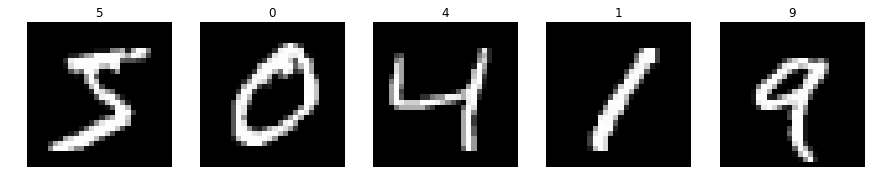

In [34]:
# show a few samples
nsamples = 5
fig, ax = plt.subplots(1, nsamples, figsize=(15,15))
# ax = fig.subplots(1,nsamples)
for i in range(nsamples):
    ax[i].imshow(np.reshape(X_train[i],(28,28)),cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(label_dict[y_train[i]])
fig.show()

In [46]:
# now create a simple 3-layer bayesian neural network in pymc3
def construct_nn(ann_input, ann_output):
    n_hidden_1 = 128
#     n_hidden_2 = 34
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(n_input, n_hidden_1).astype(floatX)
#     init_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
    init_out = np.random.randn(n_hidden_1,n_out).astype(floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1.2,
                                 shape=(n_input, n_hidden_1),
                                 testval=init_1)

#         # Weights from 1st to 2nd layer
#         weights_1_2 = pm.Normal('w_1_2', 0, sd=1.2,
#                                 shape=(n_hidden_1, n_hidden_2),
#                                 testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1.2,
                                  shape=(n_hidden_1,n_out),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
#         act_2 = pm.math.tanh(pm.math.dot(act_1,
#                                          weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_1,
                                              weights_2_out))
        
        # Classification
        out = pm.Categorical('out',
                           act_out,
                           observed=ann_output,
                           total_size=n_train
                          )
    return neural_network

In [67]:
# train on minibatch with ADVI
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)

In [ ]:
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(10000, method=inference)

In [79]:
with neural_network_minibatch:
    sgd_result = pm.sgd(learning_rate=.01)
    svgd_approx = pm.fit(300, method='svgd',
                         obj_optimizer=pm.sgd(learning_rate=0.01))
#     approx = pm.fit(10000, method=sgd_result)

100%|██████████| 300/300 [02:39<00:00,  1.78it/s]


In [ ]:
# plotting the training progress
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration')
plt.show()

In [81]:
# get samples of the weight
trace = approx.sample(draws=2000)

In [82]:
# network for testing with trace of the minbatch network
test_x = theano.shared(X_test)
test_y = theano.shared(y_test)
neural_network_test = construct_nn(test_x, test_y)
with neural_network_test:
    ppc = pm.sample_ppc(trace, samples=100)

100%|██████████| 100/100 [00:49<00:00,  2.08it/s]


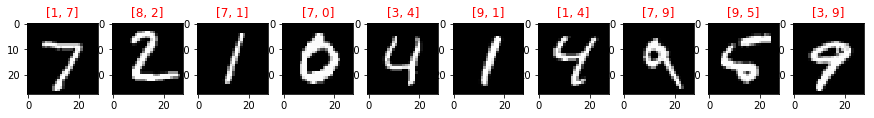

In [83]:
y_pred = mode(ppc['out'], axis=0).mode[0,:]
# show a few samples
nsamples = 10
fig, ax = plt.subplots(1, nsamples, figsize=(15,15))
# ax = fig.subplots(1,nsamples)
for i in range(nsamples):
    ax[i].imshow(np.reshape(X_test[i],(28,28)),cmap='gray')
    if y_pred[i]==y_test[i]:
        ax[i].set_title([y_pred[i],y_test[i]])
    else:
        ax[i].set_title([y_pred[i],y_test[i]],color='r')
fig.show()

In [84]:
np.mean(y_pred==y_test)

0.076600000000000001